# Final Project for "A Network Tour of Data Science"- Global Warming
### Effrosyni Simou

# 1. Aim of the Project
Since the 2016 Presidential Elections in the USA, the interest of people with regards to climate change and the correct environmental policy has reached an all-time high. In this project the aim is to use a [dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) with temperature data from 1750 to 2015 [1] and check whether global warming is a fact or a speculation. The dataset is nicely packaged and allows for slicing into interesting subsets (by country, by city, global temperatures e.t.c.). It was put together by Berkeley Earth, which is affiliated with Lawrence Berkeley National Laboratory.

# 2. Data Acquisition

In [39]:
import numpy as np
# Show matplotlib graphs inside the notebook.
%matplotlib inline
import os.path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from   sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from myutils import makeTimeSeries
from myutils import differenciate
from myutils import test_stationarity

In [40]:
import warnings
warnings.filterwarnings("ignore")

## 2.1 Importing the data

In [41]:
folder = os.path.join('data', 'temperatures','GlobalLandTemperatures')
filename_ByCity = os.path.join(folder, 'GlobalLandTemperaturesByCity.csv')
filename_ByCountry = os.path.join(folder, 'GlobalLandTemperaturesByCountry.csv')
filename_ByMajorCity = os.path.join(folder, 'GlobalLandTemperaturesByMajorCity.csv')
filename_ByState = os.path.join(folder, 'GlobalLandTemperaturesByState.csv')
filename_Global = os.path.join(folder, 'GlobalTemperatures.csv')

In [42]:
ByCity=pd.read_csv(filename_ByCity)
ByCountry=pd.read_csv(filename_ByCountry)
ByMajorCity=pd.read_csv(filename_ByMajorCity)
ByState=pd.read_csv(filename_ByState)
Global=pd.read_csv(filename_Global)

## 2.2 Looking at the data

In [43]:
ByCity[:10000].to_html('ByCity.html')
ByCountry[:10000].to_html('ByCountry.html')
ByMajorCity[:10000].to_html('ByMajorCity.html')
ByState[:10000].to_html('ByState.html')
Global.to_html('Global.html')

Export part of the dataset as HTML files for inspection [ByCity](./ByCity.html),  [ByCountry](./ByCountry.html), 
[ByMajorCity](ByMajorCity.html), [ByState](./ByState.html), [Global](./Global.html) .

As we can see by following the links above, there is a need to clean our data: 
* __There are missing data.__ For instance, in the case of the _global_ temperatures there are no measurements for maximum/minimum land temperatures as well as no measurements for  land and ocean temperatures before 1850.
* __There are duplicates in our data.__ This makes sense since the dataset was created by combining 16 pre-existing archives. For instance, in the case of temperatures _by country_ the temperatures for Denmark, France, Netherlands and United Kingdom are duplicate. Also, in the case of temperatures _by city_ the temperatures for Guatemala City are duplicate.
* __Older measurements are less reliable.__ The measurements in this dataset date as back as 1743. It is expected that older measurements will be noisy and therefore less reliable. We will visualize the uncertainty of the measurements in the next section. 

## 2.3 Cleaning the data

### 2.3.1 Removing duplicates

In [44]:
#Removing duplicates from ByCountry
ByCountry_clear = ByCountry[~ByCountry['Country'].isin(
    ['Denmark', 'France', 'Europe', 'Netherlands',
     'United Kingdom'])]
#ByCountry_clear.loc[ByCountry_clear['Country'] == 'Denmark (Europe)']
ByCountry_clear = ByCountry_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])
#countries = np.unique(ByCountry_clear['Country'])
#np.set_printoptions(threshold=np.inf)
#print(countries)

In [45]:
#Removing duplicates from ByCity
ByCity_clear = ByCity[~ByCity['City'].isin(
    ['Guatemala'])]
ByCity_clear = ByCity_clear.replace(['Guatemala City'],['Guatemala'])
#cities = np.unique(ByCity_clear['City'])
#print(cities)

### 2.3.2 Working with the missing data

As far as the missing data is concerned we can chose to either:
* Ignore the missing values
* Use the values we have in order to fill in the missing values (e.g. pad, interpolate e.t.c.).

For example, if we chose to ignore the global temperature measurement for a month where the value for LandAverageTemperature is missing we can do it as follows:

In [46]:
 Global.dropna(subset=['LandAverageTemperature']).head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


Or, if we chose to ignore the global temperature measurements for which we don't have all of the 8 fields:

In [47]:
Global.dropna(axis=0).head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1200,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1201,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1202,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1203,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1204,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


If we chose to fill in the missing values with the values of the previous corresponding measurement:

In [48]:
Global.fillna(method='pad').head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


The method we will use will depend on the problem we will try to solve with our data.

### 2.3.3 Uncertainty of measuremets with time

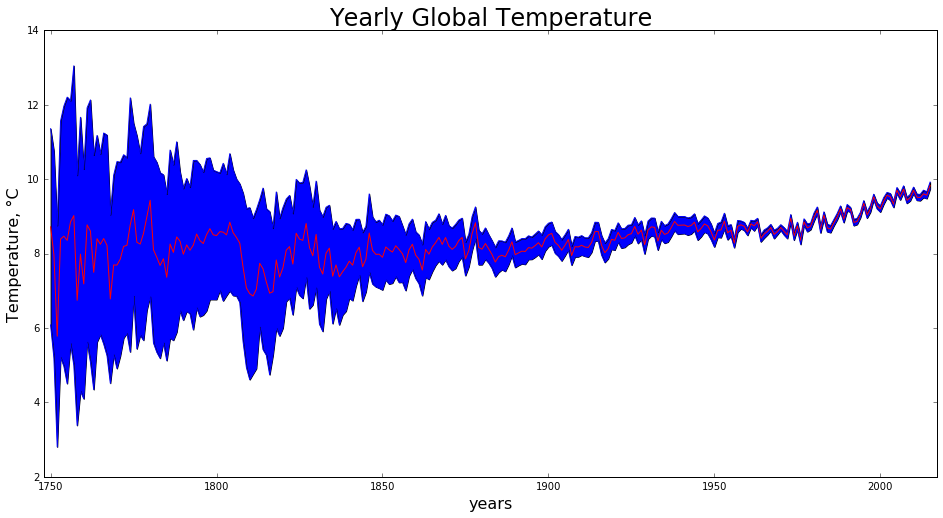

In [49]:
mean_Global= []
mean_Global_uncertainty = []
years = np.unique(Global['dt'].apply(lambda x: x[:4]))

for year in years:
    mean_Global.append(Global[Global['dt'].apply(
        lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
    mean_Global_uncertainty.append(Global[Global['dt'].apply(
                lambda x: x[:4]) == year]['LandAverageTemperatureUncertainty'].mean())

#print(years.dtype)
x=years.astype(int)
minimum=np.array(mean_Global) + np.array(mean_Global_uncertainty)
y=np.array(mean_Global)
maximum=np.array(mean_Global) - np.array(mean_Global_uncertainty)
plt.figure(figsize=(16,8))
plt.plot(x,minimum,'b')
plt.hold
plt.plot(x,y,'r')
plt.hold
plt.plot(x,maximum,'b')
plt.hold
plt.fill_between(x,y1=minimum,y2=maximum)
plt.xlabel('years',fontsize=16)
plt.xlim(1748,2017)
plt.ylabel('Temperature, °C',fontsize=16)
plt.title('Yearly Global Temperature',fontsize=24)

As it can be observed the uncertainty of the measurements in the 18th and 19th century was very high. Early data was collected by technicians using mercury thermometers, where any variation in the visit time impacted measurements. In the 1940s, the construction of airports caused many weather stations to be moved. In the 1980s, there was a move to electronic thermometers that are said to have a cooling bias. One can chose to ignore or give smaller weights to older, less reliable measurements. For the data exploitation part we will consider data from 1900 onward. 

# 3. Data Exploration

## 3.1 Which countries are warmer?

We now draw a map with the average temperature of each country over all years. This serves as a quick way to check that our data make sense. We can see that the warmest countries are the ones along the Equator and that the coldest countries are Greenland, Canada and Russia. Countries for which the data was missing are depicted as white. One can hover above counties to see their name and average temperatures.

In [50]:
countries = np.unique(ByCountry_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(ByCountry_clear[ByCountry_clear['Country'] == country]['AverageTemperature'].mean())
    #when taking the mean the missing data are automatically ignored=>see data cleaning section

#use choropleth map provided by pyplot
    
data = [ dict(
        type = 'choropleth', 
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        colorbar = dict(autotick = True, tickprefix = '', 
        title = '\n °C')
            )
       ]

layout = dict(
    title = 'Average Temperature in Countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig,validate=False)

## 3.2 Which cities have experienced the biggest change of temperature the last 50 years?

We now look at the change of temperature in the major cities over the last 50 years. We subtract the oldest temperature $T_{old }$ from the most recent temperature $T_{new}$. Therefore if $dT=T_{new}-T_{old }>0 \rightarrow$ the temperature has increased. It can be observed that for almost all (95%) of the major cities there has been an increase in the temperature in the last 50 years.   

One can zoom into the map and see the name and the coordinates of the cities. 

In [51]:
years_in_MajorCities=np.unique(ByMajorCity['dt'].apply(lambda x: x[:4]))
cities = np.unique(ByMajorCity['City'])
dt=[years_in_MajorCities[-51],years_in_MajorCities[-1]]
T1=[]
T2=[]
lon=[]
lat=[]
for city in cities:
    T1.append(ByMajorCity[(ByMajorCity['City'] == city) & (ByMajorCity['dt'].apply(lambda x: x[:4]) == dt[0])]['AverageTemperature'].mean())
    T2.append(ByMajorCity[(ByMajorCity['City'] == city) & (ByMajorCity['dt'].apply(lambda x: x[:4]) == dt[1])]['AverageTemperature'].mean())
    lon.append(ByMajorCity[ByMajorCity['City'] == city]['Longitude'].iloc[1])
    lat.append(ByMajorCity[ByMajorCity['City'] == city]['Latitude'].iloc[1])

In [52]:
lon=np.array(lon)
lat=np.array(lat)

In [53]:
for i in range(0,lon.size):
    if lon[i].endswith('W'):
        west=lon[i]
        west=float(west[:-1])
        east=str(360-west)
        lon[i]=east+'E'

In [54]:
for i in range(0,lat.size):
    if lat[i].endswith('S'):
        south=lat[i]
        south=float(south[:-1])
        north=str(1-south)
        lat[i]=north+'N'

In [55]:
lon=pd.DataFrame(lon)
lat=pd.DataFrame(lat)

In [56]:
long=lon[0].apply(lambda x: x[:-1])
lati=lat[0].apply(lambda x: x[:-1])
dT=np.array(T2)-np.array(T1)

In [57]:
data = [ dict(
        type = 'scattergeo',
        lon = long,
        lat = lati,
        text=cities,
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            color = dT,
            colorbar=dict(
                title="\n °C"
            )
        ))]

layout = dict(
        title = 'Change in the temperature the last 50 years',
        colorbar = True,   
        geo = dict(
            
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            showocean = True,
            oceancolor = 'rgb(0,255,255)',

        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)


# 4. Data Expoitation

We now want to build a model that predicts the global temperature based on the temperatures of the previous years. It can be obsereved from the figure below that the mean of the global temperature data has a positive trend. Therefore the yearly global temperature is a non-stationary process (the joint probability distribution changes when shifted in time). In order to produce reliable results and good prediction the process must be converted to a stationary process.

In [58]:
mean_Global=pd.DataFrame(mean_Global)
mean_Global['dt']=years
ts=makeTimeSeries(mean_Global)
#print(ts)

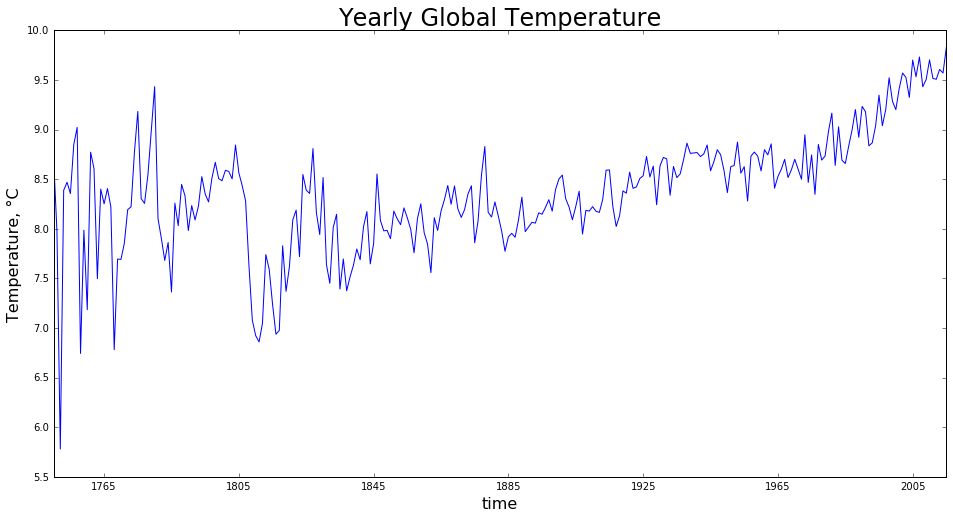

In [59]:
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.xlabel('time',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)
plt.title('Yearly Global Temperature',fontsize=24)

## 4.1 Making the process a stationary process

### 4.1.1 Differencing

An easy way to detrend a time series is by differencing. For a non-stationary time series $X$, its corresponding time series after differencing $X_{diff}$ can be calculated as:<br><br>
$$
X_{diff}(i)=X(i)-X(i-1)
$$
$X_{diff}$ will obviously have one sample less than $X$. 

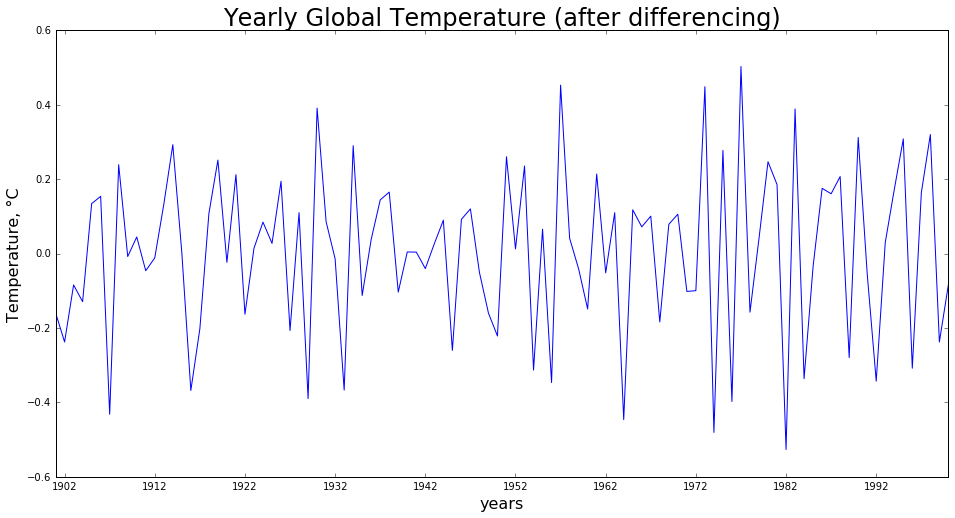

In [60]:
X = ts[0]['1900':'2000'] #training set, temporal split
#print(X)
X_diff=differenciate(X)
#print(X_diff)
plt.figure(figsize=(16,8))
plt.plot(X_diff)

plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)
plt.title('Yearly Global Temperature (after differencing)',fontsize=24)

Now we can check if in fact the process after differencing is stationary with the **Dickey-Fuller Test**. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

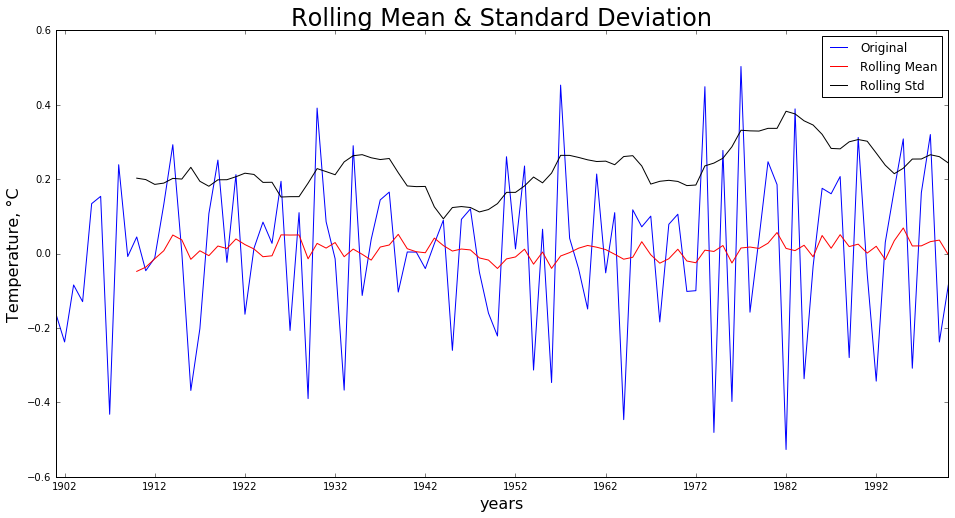

Results of Dickey-Fuller Test:
Test Statistic                 -5.370426
p-value                         0.000004
#Lags Used                      8.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [61]:
test_stationarity(X_diff)

### 4.1.2 Detrend by Model Fitting

Another way is to try to model the trend and then subtract it from the data.

In [62]:
regresor  = linear_model.LinearRegression()
y=np.array(X.dropna())
t=np.arange(y.size)
y=y.reshape(-1,1)
t=t.reshape(-1,1)
regresor.fit(t,y)
trend=regresor.predict(t)
# detrend
detrended = [y[i]-trend[i] for i in range(0, y.size)]

In [63]:
y=pd.DataFrame(y)
y.index=X.index
trend=pd.DataFrame(trend)
trend.index=X.index
detrended=pd.DataFrame(detrended)
detrended.index=X.index

In [64]:
print('Coefficients: \n', regresor.coef_)
print("Mean of error: %.2f" % np.mean((trend - y) ** 2))

Coefficients: 
 [[ 0.00803001]]
Mean of error: 0.04


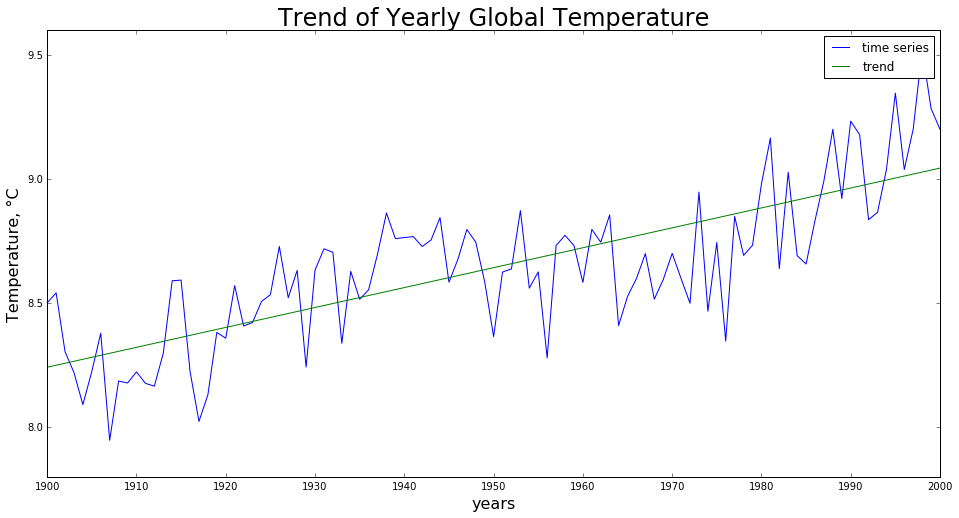

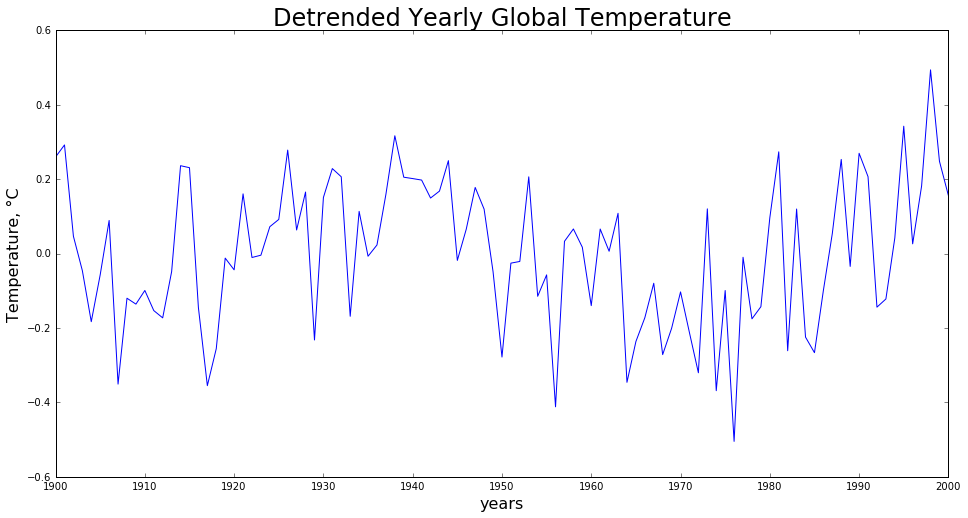

In [65]:
# plot trend
plt.figure(figsize=(16,8))
plt.plot(y,color='blue',label='time series')
plt.plot(trend,color='green',label='trend')
plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)
plt.title('Trend of Yearly Global Temperature',fontsize=24)
plt.legend()
plt.show()

# plot detrended
plt.figure(figsize=(16,8))
plt.plot(detrended)
plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)
plt.title('Detrended Yearly Global Temperature',fontsize=24)
plt.show()

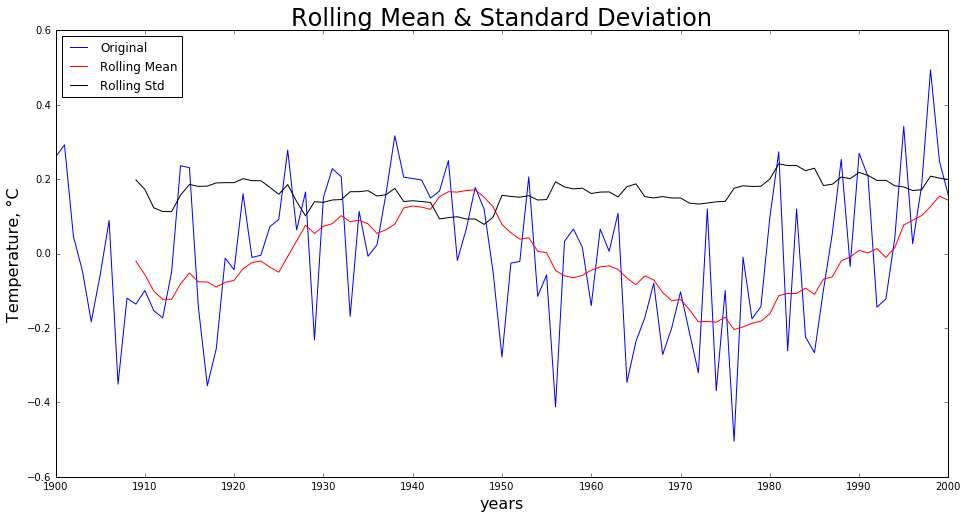

Results of Dickey-Fuller Test:
Test Statistic                 -2.876054
p-value                         0.048204
#Lags Used                      3.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


In [66]:
test_stationarity(detrended[0])

Looking at the results we get from the Dickey-Fuller Test for the two methods of making the time series stationary, we can see that we got better results here through the method of differencing. Therefore, in what follows we will use $X_{diff}$. We could have gotten better results for the method based on modeling the trend if we had allowed a more complex model than the linear one.

## 4.2 Modeling

For the modeling we will use the **Auto-Regressive Integrated Moving Averages (ARIMA)** model. For our training set we will use the global temperatures from 1900 to 2000.

The ARIMA provided by statsmodels differenciates the time series. Therefore, we give first in the figure below the results for the differenciated time series.

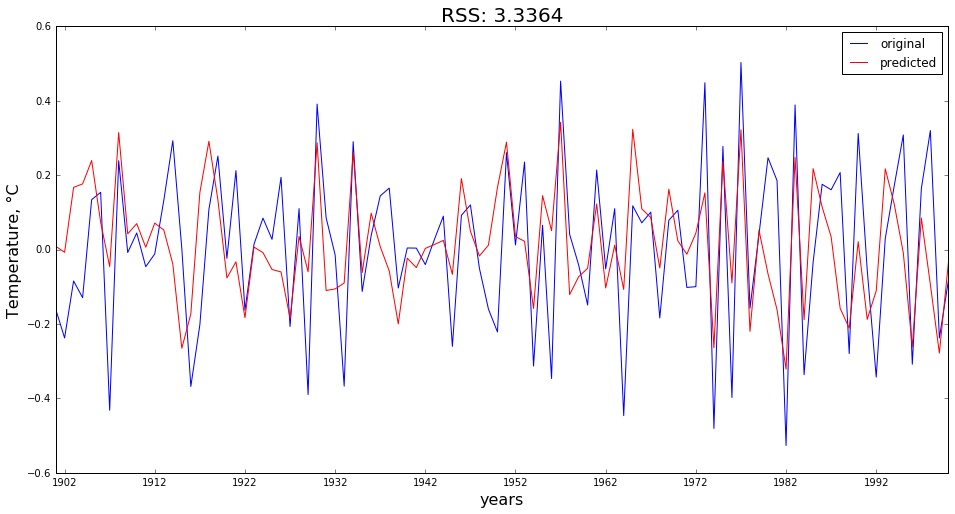

In [67]:
model = ARIMA(ts[0]['1900':'2000'], order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(16,8))
plt.plot(X_diff,color='blue',label='original')
plt.plot(results_ARIMA.fittedvalues, color='red',label='predicted')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-X_diff)**2),fontsize=20)
plt.legend(loc='best')
plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)

In [68]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print(predictions_ARIMA_diff.head())

We now take it back to the original scale (no differencing).

In [69]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print (predictions_ARIMA_diff_cumsum.head())

In [70]:
predictions_ARIMA = pd.Series(X.ix[0], index=X.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA.head()

# 5. Evaluation

## 5.1 In-sample performance

We now plot the actual and the predicted time series by our model for our training set. It is not a perfect prediction, but the root mean square error is relatively small.

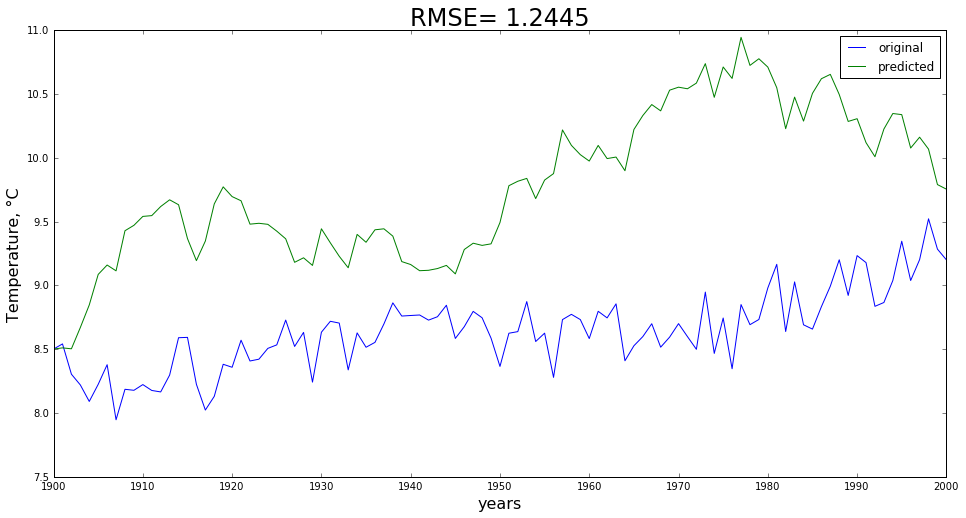

In [71]:
plt.figure(figsize=(16,8))
plt.plot(X,color='blue',label='original')
plt.plot(predictions_ARIMA,color='green',label='predicted')
plt.title('RMSE= %.4f'% np.sqrt(sum((predictions_ARIMA-X)**2)/len(X)),fontsize=24)
plt.legend(loc='best')
plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)

## 5.2 Out-of-sample performance

We now look at the accuracy of our model in predicting the future. We test on the temperatures from 2001 to 2015. Again, the model is not perfectly accurate, but the root mean square error is relatively small.

In [72]:
X_test = ts[0]['2001':] #test set, temporal split
#print(X_test)

In [73]:
preds=results_ARIMA.predict('2001-01-01','2015-01-01')

In [74]:
#preds.head

In [75]:
preds_cumsum = preds.cumsum()
preds=preds_cumsum+X[-1]
#print (preds)

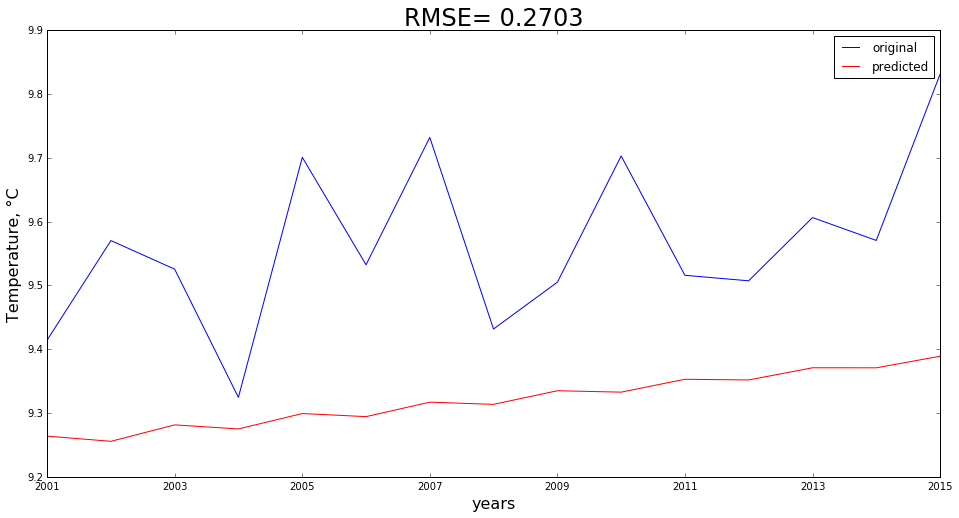

In [76]:
#print(X_test)
plt.figure(figsize=(16,8))
plt.plot(X_test,color='blue',label='original')
plt.plot(preds, color='red',label='predicted')
plt.title('RMSE= %.4f'% np.sqrt(sum((preds-X_test)**2)/len(X_test)),fontsize=24)
plt.legend(loc='best')
plt.xlabel('years',fontsize=16)
plt.ylabel('Temperature, °C',fontsize=16)

# 6. Conclusion

In conclusion, as we have seen, **global warming is a fact**. It is therefore important that nations will work towards a systematic and organized fight against climate change. 

# 7. References

[1] Climate Change: Earth Surface Temperature Data. Exploring global temperatures since 1750. Available from World Wide Web: (https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).